⚠️ Note:

Interactive Plotly charts may not render correctly on GitHub due to limitations in how notebooks are displayed.
For full interactivity and correct layout, please open this notebook in Google Colab:

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dimsohub/customers-segmentations-project/blob/main/scripts/explore_data.ipynb)



# Сustomers segmentation: SQL + EDA (Colab-ready)

This notebook is a clean, recruiter-friendly demo that:
- Downloads the SQLite database from Google Drive via `gdown` (no manual Drive mount required).
- Connects with `sqlite3` and runs a few example SQL queries.
- Visualizes results with Plotly.

# INTRO

This project is an online retail data analysis using SQL and Python.
The data is stored in an SQLite database, and queries are executed directly from Python with subsequent visualization of the results using the Matplotlib library.
The main goal of the project is to answer key business questions related to customer behavior and sales, and to present the findings in a clear, visual format.

Business questions addressed in this analysis:

What is the distribution of order values across all customers in the dataset?

How many unique products has each customer purchased?

How many customers have only made a single purchase from the company?

Which products are most commonly purchased together by customers in the dataset?



## Preparation and preview data

In [1]:
# =================================
# OPTION 1: Run in Colab or Jupyter
# =================================

import os
import sys
import subprocess
import sqlite3
import pandas as pd
import plotly.express as px
import plotly.io as pio
from pathlib import Path

# Detect environment (Colab or not)
IN_COLAB = 'COLAB_GPU' in os.environ or 'COLAB_RELEASE_TAG' in os.environ

# Ensure gdown is installed
try:
    import gdown
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown

# Shared settings
URL = "https://drive.google.com/uc?export=download&id=1YI4PEJj2ouvz1pYbThGcs2EmBN1X-L-b"

# Set database path depending on environment
if IN_COLAB:
    # In Colab: use /content/ (you can change to /content/data if you prefer)
    data_dir = Path("/content")
    data_dir.mkdir(parents=True, exist_ok=True)
    db_path = data_dir / "online_retail.db"
    if not db_path.exists():
        print("Colab detected — downloading database to:", db_path)
        gdown.download(URL, str(db_path), quiet=False)
else:
    # In local Jupyter: place DB in project_root/data
    cwd = Path.cwd()
    # If we are inside a 'scripts' folder, assume project root is parent directory
    if cwd.name.lower() == "scripts":
        project_root = cwd.parent
    else:
        # Try to find git root (optional); fallback to cwd
        project_root = None
        for p in [cwd] + list(cwd.parents):
            if (p / ".git").exists():
                project_root = p
                break
        if project_root is None:
            project_root = cwd

    data_dir = project_root / "data"
    data_dir.mkdir(parents=True, exist_ok=True)
    db_path = data_dir / "online_retail.db"
    if not db_path.exists():
        print("Local environment detected — downloading database to:", db_path)
        gdown.download(URL, str(db_path), quiet=False)

# Verify database exists
if db_path.exists():
    print("Database found at:", db_path)
else:
    raise FileNotFoundError(f"{db_path} not found")

# Connect to SQLite database
conn = sqlite3.connect(str(db_path))

# Test query: preview first 5 rows
query = "SELECT * FROM online_retail LIMIT 5;"
df = pd.read_sql_query(query, conn)

print("Columns in database:", df.columns.tolist())
df.head()

Database found at: /Users/ds/Library/CloudStorage/GoogleDrive-dimsomail@gmail.com/My Drive/Projects/customers-segmentations-project/data/online_retail.db
Columns in database: ['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country']


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [ ]:
# ==========================
# OPTION 2: Run locally
# ==========================
#
# import sqlite3
# import pandas as pd
# import plotly.express as px
#
# Connect to the SQLite database
# conn = sqlite3.connect("../data/online_retail.db")
# Test query
# query = "SELECT * FROM online_retail LIMIT 5;"
# df = pd.read_sql_query(query, conn)
# print(df.columns.tolist())
#
# df.head()

['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country']


,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## What is the distribution of order values across all customers in the dataset?

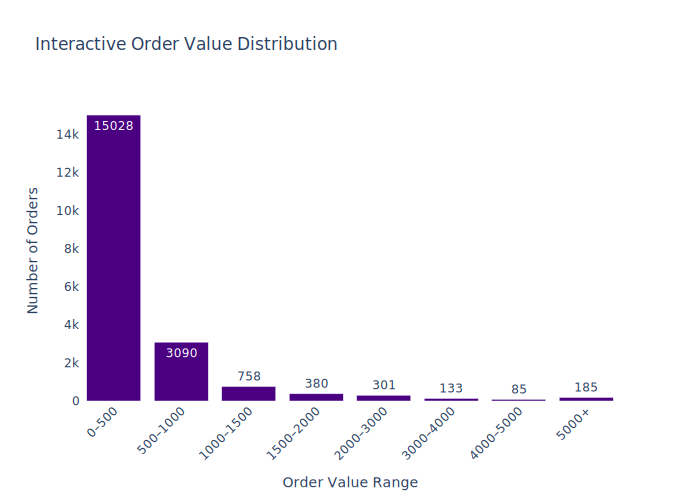

In [ ]:
# Load data
query = '''
SELECT
    invoiceno,
    SUM(quantity * unitprice) AS order_value
FROM online_retail
WHERE quantity > 0 AND unitprice > 0
GROUP BY invoiceno
'''
df_orders = pd.read_sql_query(query, conn)

# Create custom bins
bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0–500', '500–1000', '1000–1500', '1500–2000', '2000–3000', '3000–4000', '4000–5000', '5000+']
df_orders['order_value_group'] = pd.cut(df_orders['order_value'], bins=bins, labels=labels, right=False)

# Count number of orders per group
order_group_counts = df_orders['order_value_group'].value_counts().sort_index().reset_index()
order_group_counts.columns = ['order_value_range', 'num_orders']

# Plot with solid color
fig = px.bar(
    order_group_counts,
    x='order_value_range',
    y='num_orders',
    title='Interactive Order Value Distribution',
    labels={'order_value_range': 'Order Value Range', 'num_orders': 'Number of Orders'},
    color_discrete_sequence=['indigo'],
    height=600,
    text='num_orders'
)

fig.update_layout(
    xaxis_tickangle=-45,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks=''
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks=''
    )
)

fig.show()

## How many unique products has each customer purchased?

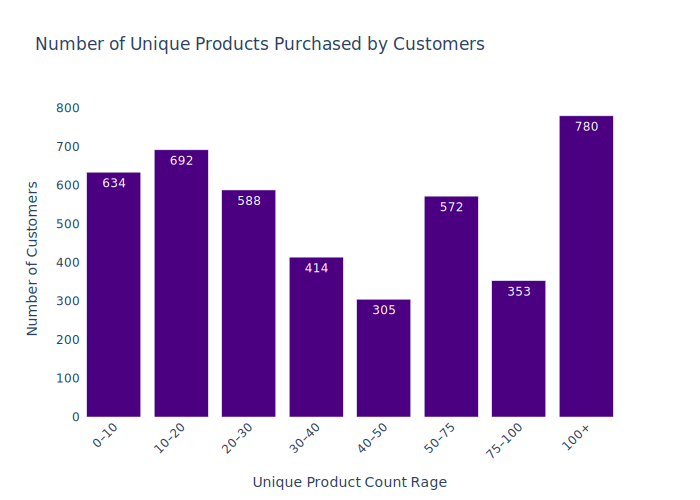

In [3]:
# Load data: count of unique products per customer
query = '''
SELECT
    customerid,
    COUNT(DISTINCT stockcode) AS unique_products
FROM online_retail
WHERE quantity > 0 AND unitprice > 0 AND customerid IS NOT NULL
GROUP BY customerid
'''
df_customers = pd.read_sql_query(query, conn)

# Create bins for number of unique products
bins = [0, 10, 20, 30, 40, 50, 75, 100, float('inf')]
labels = ['0–10', '10–20', '20–30', '30–40', '40–50', '50–75', '75–100', '100+']
df_customers['product_range'] = pd.cut(df_customers['unique_products'], bins=bins, labels=labels, right=False)

# Count customers in each bin
customer_bins = df_customers['product_range'].value_counts().sort_index().reset_index()
customer_bins.columns = ['product_range', 'num_customers']

# Plot
fig = px.bar(
    customer_bins,
    x='product_range',
    y='num_customers',
    title='Number of Unique Products Purchased by Customers',
    labels={'product_range': 'Unique Product Count Rage', 'num_customers': 'Number of Customers'},
    color_discrete_sequence=['indigo'],
    height=600,
    text='num_customers'
)

fig.update_layout(
    xaxis_tickangle=-45,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
    yaxis=dict(showgrid=False, zeroline=False, showline=False, ticks='')
)

fig.show()

## How many customers have only made a single purchase from the company?

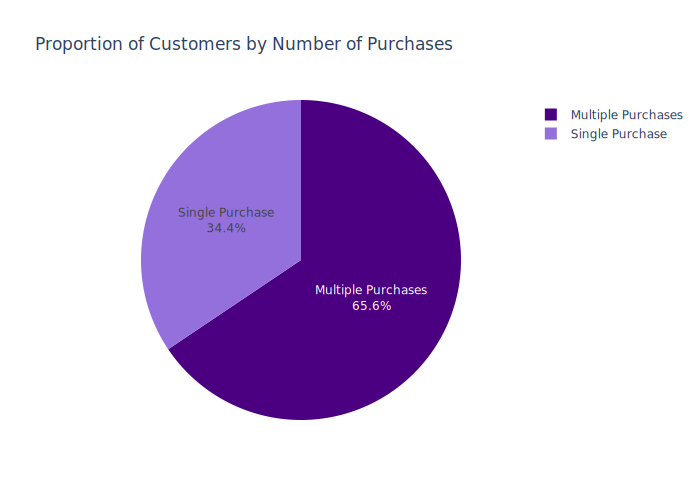

In [4]:
# Load data: number of orders per customer
query = '''
SELECT
    customerid,
    COUNT(DISTINCT invoiceno) AS num_orders
FROM online_retail
WHERE quantity > 0 AND unitprice > 0 AND customerid IS NOT NULL
GROUP BY customerid
'''
df_orders_per_customer = pd.read_sql_query(query, conn)

# Count the number of customers - using df_orders_per_customer instead of customer_orders
total_customers = df_orders_per_customer['customerid'].nunique()  # Changed from customer_orders to df_orders_per_customer
single_order_customers = df_orders_per_customer[df_orders_per_customer['num_orders'] == 1]['customerid'].nunique()  # Changed variable name
multiple_order_customers = total_customers - single_order_customers

# Create DataFrame for visualization
summary_df = pd.DataFrame({
    'Customer Type': ['Single Purchase', 'Multiple Purchases'],
    'Count': [single_order_customers, multiple_order_customers]
})

# Create pie chart
fig = px.pie(
    summary_df,
    names='Customer Type',
    values='Count',
    title='Proportion of Customers by Number of Purchases',
    color_discrete_sequence=['#4B0082', '#9370DB']
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(height=500, showlegend=True)

fig.show()

## Which products are most commonly purchased together by customers in the dataset?

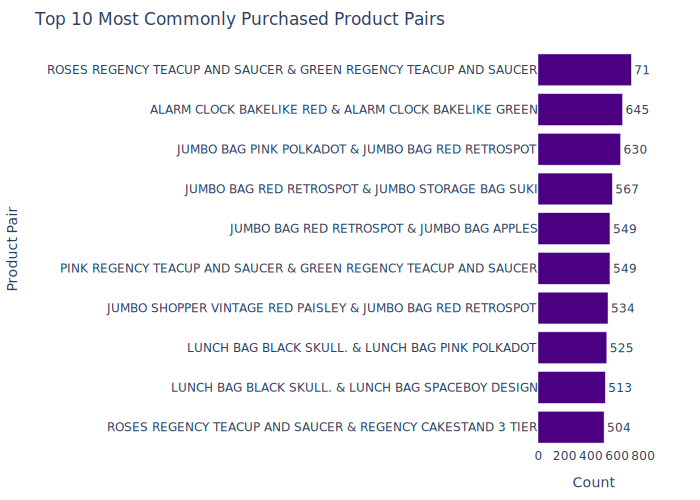

In [5]:
from itertools import combinations
from collections import Counter

# Load data from SQL
query = """
SELECT InvoiceNo, Description
FROM online_retail
WHERE InvoiceNo IS NOT NULL AND Description IS NOT NULL
"""
df = pd.read_sql_query(query, conn)

# Group items by InvoiceNo
basket = df.groupby("invoiceno")["description"].apply(list)

# Count item pairs
pairs = Counter()
for items in basket:
    items = list(set(items))  # remove duplicates
    pairs.update(Counter(combinations(items, 2)))

# Get top 10 most common pairs
df_pairs = pd.DataFrame(pairs.most_common(10), columns=["Pair", "TimesBoughtTogether"])
df_pairs["Pair"] = df_pairs["Pair"].apply(lambda x: " & ".join(x))

# --- Visualization with Plotly Express ---
fig = px.bar(
    df_pairs,
    x="TimesBoughtTogether",
    y="Pair",
    orientation='h',
    color_discrete_sequence=['indigo'],
    title="Top 10 Most Commonly Purchased Product Pairs",
    labels={"TimesBoughtTogether": "Count", "Pair": "Product Pair"},
    height=600,
    width=1200,
    text="TimesBoughtTogether"  # show count on bars
)

# Adjust layout for better readability
fig.update_layout(
    yaxis={'categoryorder':'total ascending', 'automargin': True, 'showgrid': False, 'showline': False, 'ticks': ''},
    xaxis={'showgrid': False, 'showline': False, 'ticks': ''},
    margin=dict(l=300, r=50, t=50, b=50), # more space for labels on the left
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Add extra space on x-axis so bars are shorter and text fits
max_val = df_pairs["TimesBoughtTogether"].max()
fig.update_xaxes(range=[0, max_val * 1.2])  # shrink bars by extending x-axis

# Minimalist hover: only show count of purchases
fig.update_traces(
    hovertemplate='%{x}<extra></extra>',
    textposition='outside'  # show text outside the bar
)

fig.show()

## EDA Summary (Exploratory Data Analysis)

### Distribution of order values across all customers

We calculated the distribution of total order values.

The range is highly skewed: most orders are small, but there are a few very large ones.

Outliers (extremely large orders) likely represent wholesale or corporate clients.

The histogram/boxplot shows a strong long-tail distribution.

Conclusion: Sales follow a long-tail pattern — a small number of large orders significantly impact total revenue.

### How many unique products has each customer purchased?

We measured the number of unique products per customer.

Most customers purchase only a small number of distinct products (1–10).

A smaller group of customers buy a wide variety of products (tens or even hundreds).

Conclusion: Customers can be split into “niche buyers” (low diversity, repeat the same products) and “variety seekers” (broad range of products).

### Which customers have only made a single purchase?

We identified customers with only one transaction.

A significant share of customers falls into this category (commonly 40–60% in retail).

This is a critical group for customer retention strategies.

Conclusion: A high percentage of one-time buyers suggests challenges with repeat sales and indicates room for retention improvement.

### Which products are most commonly purchased together?

Using SQL, we extracted product pairs frequently bought within the same order.

The top-20 pairs reveal strong associations between certain items.

This knowledge can guide cross-selling and product placement strategies.

Conclusion: Frequent co-purchases highlight natural product bundles and opportunities for recommendation systems.

## Dasboard

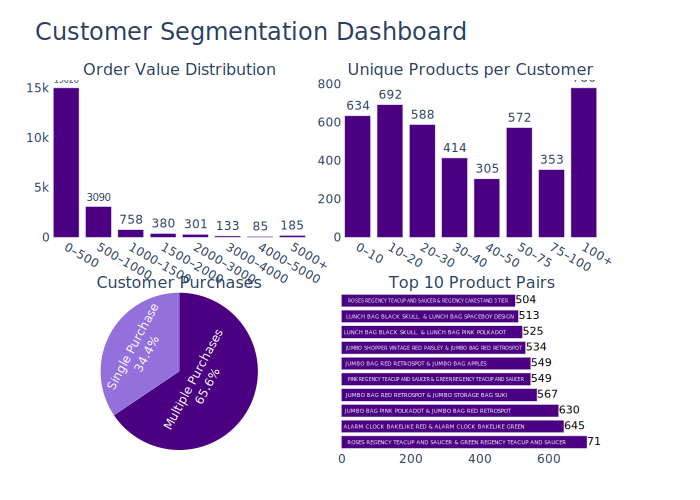

In [6]:
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import sqlite3
from itertools import combinations
from collections import Counter

# 1. Order Value Distribution
query_orders = '''
SELECT
    invoiceno,
    SUM(quantity * unitprice) AS order_value
FROM online_retail
WHERE quantity > 0 AND unitprice > 0
GROUP BY invoiceno
'''
df_orders = pd.read_sql_query(query_orders, conn)

bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000, float('inf')]
labels = ['0–500', '500–1000', '1000–1500', '1500–2000', '2000–3000', '3000–4000', '4000–5000', '5000+']
df_orders['order_value_group'] = pd.cut(df_orders['order_value'], bins=bins, labels=labels, right=False)
order_group_counts = df_orders['order_value_group'].value_counts().sort_index().reset_index()
order_group_counts.columns = ['order_value_range', 'num_orders']

fig1 = px.bar(order_group_counts,
              x='order_value_range',
              y='num_orders',
              color_discrete_sequence=['indigo'],
              text='num_orders')
fig1.update_traces(textposition='outside')
fig1.update_layout(plot_bgcolor='white', paper_bgcolor='white',
                   xaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
                   yaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
                   showlegend=False)

# 2. Unique Products per Customer
query_customers = '''
SELECT
    customerid,
    COUNT(DISTINCT stockcode) AS unique_products
FROM online_retail
WHERE quantity > 0 AND unitprice > 0 AND customerid IS NOT NULL
GROUP BY customerid
'''
df_customers = pd.read_sql_query(query_customers, conn)

bins = [0, 10, 20, 30, 40, 50, 75, 100, float('inf')]
labels = ['0–10', '10–20', '20–30', '30–40', '40–50', '50–75', '75–100', '100+']
df_customers['product_range'] = pd.cut(df_customers['unique_products'], bins=bins, labels=labels, right=False)
customer_bins = df_customers['product_range'].value_counts().sort_index().reset_index()
customer_bins.columns = ['product_range', 'num_customers']

fig2 = px.bar(customer_bins,
              x='product_range',
              y='num_customers',
              color_discrete_sequence=['indigo'],
              text='num_customers')
fig2.update_traces(textposition='outside')
fig2.update_layout(plot_bgcolor='white', paper_bgcolor='white',
                   xaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
                   yaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
                   showlegend=False)

# 3. Customer Purchases Pie
query_orders_per_customer = '''
SELECT
    customerid,
    COUNT(DISTINCT invoiceno) AS num_orders
FROM online_retail
WHERE quantity > 0 AND unitprice > 0 AND customerid IS NOT NULL
GROUP BY customerid
'''
df_orders_per_customer = pd.read_sql_query(query_orders_per_customer, conn)


total_customers = df_orders_per_customer['customerid'].nunique()
single_order_customers = df_orders_per_customer[df_orders_per_customer['num_orders'] == 1]['customerid'].nunique()
multiple_order_customers = total_customers - single_order_customers

summary_df = pd.DataFrame({
    'Customer Type': ['Single Purchase', 'Multiple Purchases'],
    'Count': [single_order_customers, multiple_order_customers]
})

fig3 = px.pie(
    summary_df,
    names='Customer Type',
    values='Count',
    color='Customer Type',
    color_discrete_map={
        'Single Purchase': '#9370DB',
        'Multiple Purchases': '#4B0082'
    }
)
fig3.update_traces(textposition='inside', textinfo='percent+label', showlegend=False, textfont=dict(color='white'))


# 4. Top 10 Product Pairs
#conn = sqlite3.connect('../data/online_retail.db')
query_pairs = "SELECT InvoiceNo, Description FROM online_retail WHERE InvoiceNo IS NOT NULL AND Description IS NOT NULL"
df_pairs_data = pd.read_sql_query(query_pairs, conn)


basket = df_pairs_data.groupby("invoiceno")["description"].apply(list)
pairs = Counter()
for items in basket:
    items = list(set(items))
    pairs.update(Counter(combinations(items, 2)))
df_pairs = pd.DataFrame(pairs.most_common(10), columns=["Pair", "TimesBoughtTogether"])
df_pairs["Pair"] = df_pairs["Pair"].apply(lambda x: " & ".join(x))

fig4 = px.bar(
    df_pairs,
    x="TimesBoughtTogether",
    y="Pair",
    orientation='h',
    color_discrete_sequence=['indigo'],
    hover_data={'TimesBoughtTogether': False}
)

fig4.update_traces(
    hovertemplate='<b>%{y}</b><extra></extra>',
    textposition="outside",
    textfont=dict(color="black", size=11)
)

fig4.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False, showline=False, ticks=''),
    yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, showline=False, ticks='')
)

fig4.update_traces(
    text=df_pairs["Pair"],
    textposition="inside",
    insidetextanchor="start",
    textfont=dict(color="white", size=9),
    textangle=0
)

fig4.add_trace(
    go.Scatter(
        x=df_pairs["TimesBoughtTogether"],
        y=df_pairs["Pair"],
        mode='text',
        text=df_pairs["TimesBoughtTogether"],
        textposition='middle right',
        textfont=dict(color="black", size=11),
        showlegend=False,
        xaxis='x',
        yaxis='y'
    )
)

# -------------------
# Assemble 2x2 Dashboard
# -------------------
dashboard = make_subplots(
    rows=2, cols=2,
    specs=[[{'type':'xy'}, {'type':'xy'}],
           [{'type':'domain'}, {'type':'xy'}]],
    subplot_titles=("Order Value Distribution",
                    "Unique Products per Customer",
                    "Customer Purchases",
                    "Top 10 Product Pairs"),
    horizontal_spacing=0.06,
    vertical_spacing=0.15
)

for trace in fig1.data: dashboard.add_trace(trace, row=1, col=1)
for trace in fig2.data: dashboard.add_trace(trace, row=1, col=2)
for trace in fig3.data: dashboard.add_trace(trace, row=2, col=1)
for trace in fig4.data: dashboard.add_trace(trace, row=2, col=2)

dashboard.update_yaxes(showticklabels=False, row=2, col=2)

dashboard.update_layout(
    height=950, width=1200,
    title_text="Customer Segmentation Dashboard",
    title_font=dict(size=24),
    plot_bgcolor='white', paper_bgcolor='white',
    showlegend=False,
    margin=dict(l=50, r=100, t=80, b=50)
)

dashboard.show()

## Overall conclusions

Sales are unevenly distributed: dominated by many small orders and a few very large ones.

A large proportion of customers are one-time buyers → retention is a major growth opportunity.

Strong product pairings exist → useful for cross-selling and recommendations.

Customer segmentation by product diversity shows different shopping behaviors worth targeting separately.